# PHYS 462 Computational Project - Fermi Gas in a Box
### Author: Ansh Gupta

## Background:
Fermions are particles with a half-integer spin, like $\frac{1}{2}$, $\frac{3}{2}$, etc. Unlike bosons, they obey the Pauli exclusion principle, meaning that two fermions cannot occupy the same quantum state. This fact results in many of the characteristics and properties of a "fermi gas" at low temperatures and/or high densities, when quantum effects are not negligible.

## Project Description:
Consider a system of fermions in a 3 dimensional, cubical box with side length $L$. Treating the problem as a classic 3D particle in a box, the energy eigenvalues for an individual fermion can be found as follows:\
$$\epsilon_{\vec{n}} = \frac{\pi^2\hbar^2\vec{n}^2}{2mL^2}$$
A treatment of this problem can be found in many introductory quantum mechanics textbooks (eg. *Introduction to Quantum Mechanics* by Griffiths and Schroeter). 3 quantum numbers, $n_x, n_y,$ and $n_z,$ must be introduced to express the allowed energy eigenvalues for a particle in a 3D box. Then the quantity $\vec{n}^2 = n_x^2 + n_y^2 + n_z^2$.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.optimize import curve_fit

In [18]:
hbar = 1.055e-34 # reduced Planck's constant in units of J*s
m = 9.109e-31 # mass of electron in kg
kB = 1.381e-23 # Boltzman constant in units of J/K

In [19]:
@njit
def state_energy(n_sq_mag, L):
    ''' Function that computes the energy of a particle in a 3D box in a state with 
        specified quantum numbers and the side length of the box.
        
    Inputs:
        n_sq_mag: `int`
            Square magnitude of the n vector, or nx^2 + ny^2 + nz^2
        L: `float`
            Side length of the 3D cube (meters)
    Returns: 
        energy_of_state: `float`
            Calculated energy of a particle-in-a-box in the given state
    '''
    
    energy_of_state = np.pi**2 * hbar**2 * n_sq_mag / (2 * m * L**2)
    return energy_of_state

In [20]:
@njit
def FD_distribution(n_sq_mag, L, beta, mu):
    ''' Function that computes the value of the Fermi_Dirac distribution for a particle in
        a 3D box in a state with specified quantum numbers, given the side length of the box
        and the "thermodynamic beta" (1/kT) and chemical potential.
        
    Inputs:
        n_sq_mag: `int`
            Square magnitude of the n vector, or nx^2 + ny^2 + nz^2
        L: `float`
            Side length of the 3D cube (meters)
        beta: `float`
            Thermodynamic beta (1/kT) in units of eV
        mu: `float`
            Chemical potential of fermi gas in units of eV
    Returns: 
        FD: `float`
            Calculated value of the Fermi-Dirac distribution
    '''
    
    FD = 1 / (1 + np.exp(beta * (state_energy(n_sq_mag, L) - mu)) )
    return FD

In [21]:
@njit
def system_energy(beta, mu, L_min, L_max, n_L=100, n_max=100):
    ''' Function that computes the average energy of a system of fermions in a 3D box
        by summing over all combinations of quantum numbers to a specified upper limit.
        Energy values for a range of lengths are computed and returned.
        
    Inputs:
        beta: `float`
            Thermodynamic beta (1/kT) in units of eV
        mu: `float`
            Chemical potential of fermi gas in units of eV
        L_min: `float`
            Lower limit of box side length values
        L_max: `float`
            Higher limit of box side length values
        n_L: `integer`
            Number of values between L_min and L_max to use for energy calculation
        n_max: `integer`
            Maximum number of each spatial quantum number to iterate through
        
    Returns: 
        L: `numpy array`
            Values for the box side length used in the system energy calculation
        E: `numpy array`
            Calculated average system energy at each value for box side length
    '''

    L = np.linspace(L_min, L_max, n_L)# array of L values to iterate through
    E = np.zeros(n_L) # empty array to store energy of system for each L
    
    for index, l in enumerate(L): # iterate through each box side length
        
        # iterate through combinations of quantum numbers nx, ny, and nz up to n_max
        for nx in range(1, n_max):
            for ny in range(1, n_max):
                for nz in range(1, n_max):
                    
                    n_sq_mag = nx**2 + ny**2 + nz**2 # square magnitude of n vector

                    # sum over energy of all states times FD distribution, which is a sum of energies
                    # weighted by the probability of a given state being occupied. Factor of 2 added
                    # to account for spin degeneracy of quantum states
                    E[index] += 2*state_energy(n_sq_mag, l)*FD_distribution(n_sq_mag, l, beta, mu)

    return L, E

In [22]:
def expected_energy_relation(L, rho, sigma, delta_E):
    ''' Function that computes the expected relationship between the side lengths of a 3
        dimensional cube and the average energy of a system of fermions in that box. The
        relationship is defined by the energy density of bulk Fermi gas, the surface
        energy, and a fluctuating term.
    
    Inputs:
        L: `numpy array`
            Array of values for the side length of a 3 dimensional box
        rho: `float`
            Energy density of the Fermi gas
        sigma: `float`
            Surface energy of the system
        delta_E: `float`
            Small fluctuating term that characterizes the deviations of the energy
    
    Outputs:
        E_over_L_squared: `numpy array`
            Calculated average system energy over side length squared
    '''
    
    # Equation is E = rho*V + sigma*A + deltaE, where V = L^3 and A = 6L^2
    # Divide by L^2: E/L^2 = rho*L + 6*sigma + deltaE/L^2
    E_over_L_squared = rho*L + 6*sigma + delta_E/(L**2)
    return E_over_L_squared

Calculated parameters:  rho = 1.57e+02 J/m^3,  sigma = -5.61e-07 J/m^2,  delta_E = 5.94e-22 J


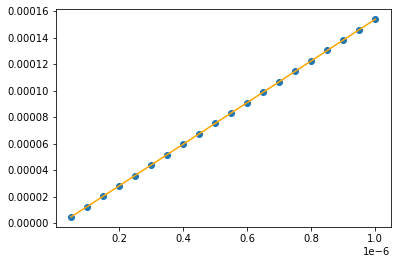

In [72]:
T_low = 3 # temperature of fermion gas in Kelvin (low temperature)
beta_low = 1/(kB*T_low) # definition of thermodynamic beta
mu_low = 10/beta_low # Set checmical potential such that beta*mu = 10

# Calculate the energy of the system from L of 10 nm to 300 nm
L_low, E_low = system_energy(beta_low, mu_low, 5e-8, 1e-6, n_L=20, n_max=100)

popt_low, pcov_low = curve_fit(expected_energy_relation, L_low, E_low/(L_low**2))
print(f"Calculated parameters:  rho = {popt_low[0]:.2e} J/m^3,  sigma = {popt_low[1]:.2e} J/m^2,  " +\
      f"delta_E = {popt_low[2]:.2e} J")

plt.scatter(L_low, E_low/(L_low**2))
plt.plot(L_low, expected_energy_relation(L_low, *popt_low), c='orange');

Calculated parameters:  rho = 3.12e+05 J/m^3,  sigma = -1.96e-04 J/m^2,  delta_E = 8.36e-21 J


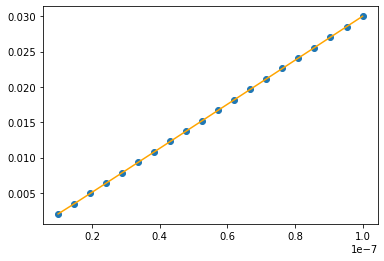

In [73]:
T_medium = 300 # temperature of fermion gas in Kelvin (intermediate temperature)
beta_medium = 1/(kB*T_medium) # definition of thermodynamic beta
mu_medium = 1/beta_medium # Set checmical potential such that beta*mu = 1

L_medium, E_medium = system_energy(beta_medium, mu_medium, 1e-8, 1e-7, 20, 100)

popt_medium, pcov_medium = curve_fit(expected_energy_relation, L_medium, E_medium/(L_medium**2))
print(f"Calculated parameters:  rho = {popt_medium[0]:.2e} J/m^3,  sigma = {popt_medium[1]:.2e} J/m^2,  " +\
      f"delta_E = {popt_medium[2]:.2e} J")

plt.scatter(L_medium, E_medium/(L_medium**2))
plt.plot(L_medium, expected_energy_relation(L_medium, *popt_medium), c='orange');

Calculated parameters:  rho = 4.66e+07 J/m^3,  sigma = -9.69e-03 J/m^2,  delta_E = 4.37e-20 J


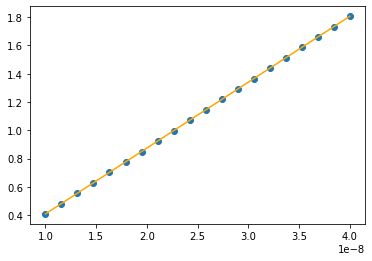

In [74]:
T_high = 3000 # temperature of fermion gas in Kelvin (high temperature)
beta_high = 1/(kB*T_high) # definition of thermodynamic beta
mu_high = 0.1/beta_high # Set checmical potential such that beta*mu = 0.1

L_high, E_high = system_energy(beta_high, mu_high, 1e-8, 4e-8, 20, 100)

popt_high, pcov_high = curve_fit(expected_energy_relation, L_high, E_high/(L_high**2))
print(f"Calculated parameters:  rho = {popt_high[0]:.2e} J/m^3,  sigma = {popt_high[1]:.2e} J/m^2,  " +\
      f"delta_E = {popt_high[2]:.2e} J")

plt.scatter(L_high, E_high/(L_high**2))
plt.plot(L_high, expected_energy_relation(L_high, *popt_high), c='orange');